In [61]:
import numpy as np
import pandas as pd
import seaborn as sns
from astropy.table import Table, Column
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.display.max_columns = 150
pd.options.display.float_format = '{:.2f}'.format

### Load, clean, merge data sets

#### Load data specific to company EXITS

In [53]:
df = pd.read_csv('company_exits.csv')
df.head()

,id,object_id,name,status,founded_at,public_at,year_founded,days_to_exit
0,c:1438,c:1438,Shutterfly,ipo,9/1/1999,9/29/2006,1999,2585
1,c:475,c:475,KIT digital,ipo,1/1/2008,7/27/2010,2008,938
2,c:108,c:108,blinkx,ipo,12/16/2004,6/22/2007,2004,918
3,c:4018,c:4018,Baidu,ipo,10/11/1999,8/5/2005,1999,2125
4,c:1972,c:1972,Salesforce,ipo,1/1/1999,7/2/2004,1999,2009


##### Load total investment data frame

In [54]:
inv = pd.read_csv('investment.csv', encoding='latin')
inv['funded_year'] = inv.funded_at.str[:4]
inv.head()

,funding_round_id,funded_object_id,funded_entity_type,funded_name,funded_category,funded_object_status,investor_object_id,investor_entity_type,investor_name,investor_category,investor_object_status,funded_at,funding_round_type,raised_amount_usd,pre_money_valuation_usd,post_money_valuation_usd,participants,is_first_round,is_last_round,funding_total_usd,funding_rounds,funded_year
0,1,c:4,Company,Digg,news,acquired,f:1,FinancialOrg,Greylock Partners,NaN,operating,2006-12-01,series-b,8500000.00,nan,nan,2,0,0,45000000.00,4,2006
1,1,c:4,Company,Digg,news,acquired,f:2,FinancialOrg,Omidyar Network,NaN,operating,2006-12-01,series-b,8500000.00,nan,nan,2,0,0,45000000.00,4,2006
2,2,c:5,Company,Facebook,social,ipo,p:26,Person,Peter Thiel,NaN,operating,2004-09-01,angel,500000.00,nan,nan,2,0,1,2425700000.00,11,2004
3,2,c:5,Company,Facebook,social,ipo,p:570,Person,Reid Hoffman,NaN,operating,2004-09-01,angel,500000.00,nan,nan,2,0,1,2425700000.00,11,2004
4,3,c:5,Company,Facebook,social,ipo,f:4,FinancialOrg,Accel Partners,NaN,operating,2005-05-01,series-a,12700000.00,115000000.00,nan,3,0,0,2425700000.00,11,2005


##### Subset total investment data to only companies that exited in the given years, to add total funding amount to first data frame

In [55]:
df2 = inv[(inv.funded_object_status == 'acquired') | (inv.funded_object_status == 'ipo')].groupby(['funded_year','funded_name'],as_index=False).agg({'funding_total_usd':'mean'})
df2.drop_duplicates(inplace=True)
df2.dropna(inplace=True)
df2 = df2[(df2.funded_year != '1987') & (df2.funded_year != '1995') &
          (df2.funded_year != '1996') & (df2.funded_year != '1997') &
          (df2.funded_year != '1998')]
df2.head(15)

,funded_year,funded_name,funding_total_usd
18,1999,ACTIVE Network,219378750.00
19,1999,Affinity.com,85000000.00
20,1999,Ancestry,333200000.00
21,1999,Answers Corporation,45410000.00
22,1999,Ask.com,25000000.00
24,1999,Direct Hit,26000000.00
25,1999,GasBuddy,4000.00
26,1999,Google,25100000.00
27,1999,Hipbone,750000.00
28,1999,Kelkoo,3000000.00


##### This has duplicates, since a company can receive funding in multiple years.  Need to remove year and de-duplicate

In [56]:
df2 = df2.iloc[:,1:]
df2.drop_duplicates(inplace=True)
df2.head()

,funded_name,funding_total_usd
18,ACTIVE Network,219378750.00
19,Affinity.com,85000000.00
20,Ancestry,333200000.00
21,Answers Corporation,45410000.00
22,Ask.com,25000000.00


##### Merge data to include funding totals, and check to make sure lengths are the same

In [57]:
exitdata = pd.merge(df, df2, how='left',left_on='name',right_on='funded_name')
exitdata.drop('funded_name', axis=1, inplace=True)
print(len(exitdata))
print(len(df))

3640
3640


In [69]:
exitdata.funding_total_usd.fillna(0, inplace=True)
exitdata.head()

,id,object_id,name,status,founded_at,public_at,year_founded,days_to_exit,funding_total_usd
0,c:1438,c:1438,Shutterfly,ipo,9/1/1999,9/29/2006,1999,2585,0.00
1,c:475,c:475,KIT digital,ipo,1/1/2008,7/27/2010,2008,938,20000000.00
2,c:108,c:108,blinkx,ipo,12/16/2004,6/22/2007,2004,918,0.00
3,c:4018,c:4018,Baidu,ipo,10/11/1999,8/5/2005,1999,2125,150000000.00
4,c:1972,c:1972,Salesforce,ipo,1/1/1999,7/2/2004,1999,2009,99916337.00


In [80]:
exitdata2 = exitdata[exitdata.funding_total_usd > 0]

#### Load data specific to company CLOSURES (already has funding amount included)

In [59]:
closed = pd.read_csv('closed_dates.csv')
closed.head()

,id,name,status,founded_year,founded_at,closed_at,funding_total_usd,days_to_close
0,c:36642,Industriaplex,closed,1999,1/1/1999,3/13/2010,0,4089
1,c:1172,InstantAction,closed,1999,1/1/1999,11/12/2010,50000000,4333
2,c:46155,Cytheris,closed,1999,1/1/1999,9/14/2013,45700000,5370
3,c:31549,Paracor Medical,closed,1999,1/1/1999,6/17/2012,44000000,4916
4,c:31488,Roxro Pharma,closed,1999,1/1/1999,1/1/2001,42700000,731


In [85]:
yearstats = pd.read_csv('yearly_stats.csv')
yearstats

,year,companies,closed,closed_pct,exited,exited_pct
0,1999,2236,30,0.01,351,0.16
1,2000,2544,41,0.02,292,0.11
2,2001,2279,28,0.01,262,0.11
3,2002,2205,37,0.02,257,0.12
4,2003,2479,59,0.02,234,0.09
5,2004,2828,73,0.03,255,0.09
6,2005,3580,95,0.03,285,0.08
7,2006,4689,169,0.04,321,0.07
8,2007,6765,291,0.04,331,0.05
9,2008,8502,288,0.03,296,0.03


## Visuals & Tables

#### % of closed and exited companies, trended by year

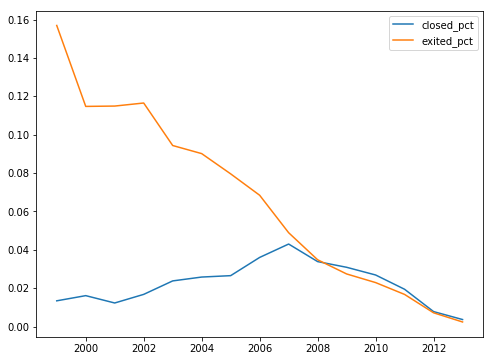

In [90]:
plt.figure(figsize = (8,6))
plt.plot('year','closed_pct', data=yearstats)
plt.plot('year','exited_pct', data=yearstats)
plt.legend()

#### Number of closed and exited companies, by year

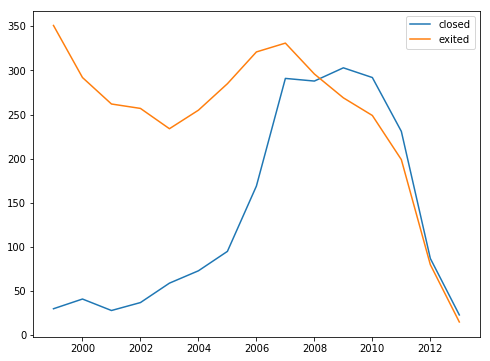

In [91]:
plt.figure(figsize = (8,6))
plt.plot('year','closed', data=yearstats)
plt.plot('year','exited', data=yearstats)
plt.legend()

#### Number of startups founded, by year

<BarContainer object of 15 artists>

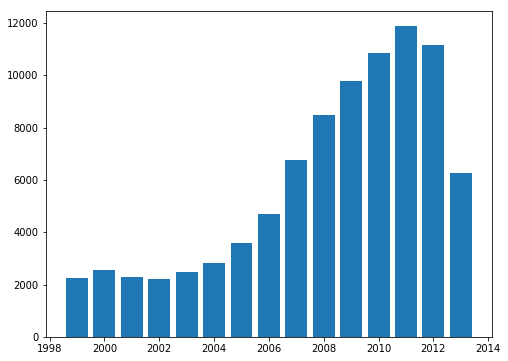

In [95]:
plt.figure(figsize = (8,6))
plt.bar('year','companies', data=yearstats)

#### Find min/max/mean days to exit and close, for each year

In [79]:
for i in range(1999,2014,1):
    print('Min/Max/Mean days to exit, %s: %d/%d/%d' %(i,exitdata.days_to_exit[exitdata.year_founded == i].min(),exitdata.days_to_exit[exitdata.year_founded == i].max(),exitdata.days_to_exit[exitdata.year_founded == i].mean()))

Min/Max/Mean days to exit, 1999: 224/5452/3767
Min/Max/Mean days to exit, 2000: 291/5093/3497
Min/Max/Mean days to exit, 2001: 207/4720/3196
Min/Max/Mean days to exit, 2002: 325/4360/2924
Min/Max/Mean days to exit, 2003: 611/3995/2625
Min/Max/Mean days to exit, 2004: 425/3610/2393
Min/Max/Mean days to exit, 2005: 31/3259/2045
Min/Max/Mean days to exit, 2006: 212/2894/1732
Min/Max/Mean days to exit, 2007: 67/2534/1451
Min/Max/Mean days to exit, 2008: 29/2156/1268
Min/Max/Mean days to exit, 2009: 18/1804/1037
Min/Max/Mean days to exit, 2010: 59/1436/783
Min/Max/Mean days to exit, 2011: 107/1068/670
Min/Max/Mean days to exit, 2012: 31/696/411
Min/Max/Mean days to exit, 2013: 66/335/163


In [82]:
for i in range(1999,2014,1):
    print('Min/Max/Mean days to close, %s: %d/%d/%d' %(i,closed.days_to_close[closed.founded_year == i].min(),closed.days_to_close[closed.founded_year == i].max(),closed.days_to_close[closed.founded_year == i].mean()))

Min/Max/Mean days to close, 1999: 731/5370/4187
Min/Max/Mean days to close, 2000: 1704/4930/3907
Min/Max/Mean days to close, 2001: 2164/4503/3571
Min/Max/Mean days to close, 2002: 1705/4246/3276
Min/Max/Mean days to close, 2003: 1096/3874/2988
Min/Max/Mean days to close, 2004: 366/3500/2552
Min/Max/Mean days to close, 2005: 365/3153/2265
Min/Max/Mean days to close, 2006: 334/2789/1842
Min/Max/Mean days to close, 2007: 13/2422/1335
Min/Max/Mean days to close, 2008: 52/2089/1106
Min/Max/Mean days to close, 2009: 48/1730/920
Min/Max/Mean days to close, 2010: 2/1369/769
Min/Max/Mean days to close, 2011: 14/993/546
Min/Max/Mean days to close, 2012: 54/690/360
Min/Max/Mean days to close, 2013: 27/413/166


#### Combine mean days to exit and close by year into one table

In [108]:
minexit = []
maxexit = []
meanexit = []
for i in range(1999, 2014,1):
    
    minexit.append(exitdata.days_to_exit[exitdata.year_founded == i].min())
        
    maxexit.append(exitdata.days_to_exit[exitdata.year_founded == i].max())
        
    meanexit.append(exitdata.days_to_exit[exitdata.year_founded == i].mean())

print(minexit)
print(maxexit)
print(meanexit)

[224, 291, 207, 325, 611, 425, 31, 212, 67, 29, 18, 59, 107, 31, 66]
[5452, 5093, 4720, 4360, 3995, 3610, 3259, 2894, 2534, 2156, 1804, 1436, 1068, 696, 335]
[3767.159420289855, 3497.794425087108, 3196.4606299212596, 2924.247058823529, 2625.7172995780593, 2393.766129032258, 2045.9892857142856, 1732.662613981763, 1451.8395061728395, 1268.0034722222222, 1037.3903345724907, 783.7782258064516, 670.0785340314136, 411.1506849315069, 163.75]


In [118]:
minclose = []
maxclose = []
meanclose = []
years = []
for i in range(1999, 2014,1):
    
    minclose.append(closed.days_to_close[closed.founded_year == i].min())
        
    maxclose.append(closed.days_to_close[closed.founded_year == i].max())
        
    meanclose.append(closed.days_to_close[closed.founded_year == i].mean())
    
    years.append(i)

print(years)    
print(minclose)
print(maxclose)
print(meanclose)

[1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013]
[731, 1704, 2164, 1705, 1096, 366, 365, 334, 13, 52, 48, 2, 14, 54, 27]
[5370, 4930, 4503, 4246, 3874, 3500, 3153, 2789, 2422, 2089, 1730, 1369, 993, 690, 413]
[4187.551724137931, 3907.7179487179487, 3571.1428571428573, 3276.2972972972975, 2988.3050847457625, 2552.5753424657532, 2265.9578947368423, 1842.4285714285713, 1335.0, 1106.537906137184, 920.439024390244, 769.1267605633802, 546.2237442922375, 360.0657894736842, 166.93333333333334]


In [119]:
t = Table()
t.add_column(Column(name = 'year',data = years))
t.add_column(Column(name = 'mean dates till close',data = meanclose))
t.add_column(Column(name = 'mean dates till exit',data = meanexit))
print(t)

year mean dates till close mean dates till exit
---- --------------------- --------------------
1999     4187.551724137931    3767.159420289855
2000    3907.7179487179487    3497.794425087108
2001    3571.1428571428573   3196.4606299212596
2002    3276.2972972972975    2924.247058823529
2003    2988.3050847457625   2625.7172995780593
2004    2552.5753424657532    2393.766129032258
2005    2265.9578947368423   2045.9892857142856
2006    1842.4285714285713    1732.662613981763
2007                1335.0   1451.8395061728395
2008     1106.537906137184   1268.0034722222222
2009      920.439024390244   1037.3903345724907
2010     769.1267605633802    783.7782258064516
2011     546.2237442922375    670.0785340314136
2012     360.0657894736842    411.1506849315069
2013    166.93333333333334               163.75


#### Find min/max/mean funding amounts for exited and closed companies, for each year

In [84]:
for i in range(1999,2014,1):
    print('Min/Max/Mean total funding amount, %s: %d/%d/%d' %(i,exitdata.funding_total_usd[exitdata.year_founded == i].min(),exitdata.funding_total_usd[exitdata.year_founded == i].max(),exitdata.funding_total_usd[exitdata.year_founded == i].mean()))

Min/Max/Mean total funding amount, 1999: 0/219378750/10976353
Min/Max/Mean total funding amount, 2000: 0/238209999/12655947
Min/Max/Mean total funding amount, 2001: 0/502860000/11722912
Min/Max/Mean total funding amount, 2002: 0/283929977/12369438
Min/Max/Mean total funding amount, 2003: 0/5700000000/40302459
Min/Max/Mean total funding amount, 2004: 0/2425700000/28994264
Min/Max/Mean total funding amount, 2005: 0/575000000/20053680
Min/Max/Mean total funding amount, 2006: 0/1160166511/20004849
Min/Max/Mean total funding amount, 2007: 0/860213000/14035675
Min/Max/Mean total funding amount, 2008: 0/1147288416/9270245
Min/Max/Mean total funding amount, 2009: 0/356962756/4340144
Min/Max/Mean total funding amount, 2010: 0/258462423/5056758
Min/Max/Mean total funding amount, 2011: 0/52588928/1391362
Min/Max/Mean total funding amount, 2012: 0/4400000/297849
Min/Max/Mean total funding amount, 2013: 0/248000000/20666666


In [83]:
for i in range(1999,2014,1):
    print('Min/Max/Mean total funding amount, %s: %d/%d/%d' %(i,closed.funding_total_usd[closed.founded_year == i].min(),closed.funding_total_usd[closed.founded_year == i].max(),closed.funding_total_usd[closed.founded_year == i].mean()))

Min/Max/Mean total funding amount, 1999: 0/50000000/18809649
Min/Max/Mean total funding amount, 2000: 0/148000000/19948475
Min/Max/Mean total funding amount, 2001: 0/98170000/15015413
Min/Max/Mean total funding amount, 2002: 0/158700000/15126017
Min/Max/Mean total funding amount, 2003: 0/49600000/11610918
Min/Max/Mean total funding amount, 2004: 0/118500000/13594051
Min/Max/Mean total funding amount, 2005: 0/211403000/10571269
Min/Max/Mean total funding amount, 2006: 0/125000000/5714046
Min/Max/Mean total funding amount, 2007: 0/510000000/3743170
Min/Max/Mean total funding amount, 2008: 0/55600000/1827522
Min/Max/Mean total funding amount, 2009: 0/170604000/1171306
Min/Max/Mean total funding amount, 2010: 0/100000000/1419459
Min/Max/Mean total funding amount, 2011: 0/6000000/303367
Min/Max/Mean total funding amount, 2012: 0/1500000/126322
Min/Max/Mean total funding amount, 2013: 0/125000/12686


#### Combine funding amounts for exited and closed by year into one table

In [120]:
minfundexit = []
maxfundexit = []
meanfundexit = []
for i in range(1999, 2014,1):
    
    minfundexit.append(exitdata.funding_total_usd[exitdata.year_founded == i].min())
        
    maxfundexit.append(exitdata.funding_total_usd[exitdata.year_founded == i].max())
        
    meanfundexit.append(exitdata.funding_total_usd[exitdata.year_founded == i].mean())

print(minfundexit)
print(maxfundexit)
print(meanfundexit)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[219378750.0, 238209999.0, 502860000.0, 283929977.0, 5700000000.0, 2425700000.0, 575000000.0, 1160166511.0, 860213000.0, 1147288416.0, 356962756.0, 258462423.0, 52588928.0, 4400000.0, 248000000.0]
[10976353.513043478, 12655947.731707318, 11722912.141732283, 12369438.85490196, 40302459.729957804, 28994264.01612903, 20053680.675, 20004849.893617023, 14035675.01234568, 9270245.888888888, 4340144.695167286, 5056758.306451613, 1391362.1570680628, 297849.31506849313, 20666666.666666668]


In [121]:
minfundclose = []
maxfundclose = []
meanfundclose = []
for i in range(1999, 2014,1):
    
    minfundclose.append(closed.funding_total_usd[closed.founded_year == i].min())
        
    maxfundclose.append(closed.funding_total_usd[closed.founded_year == i].max())
        
    meanfundclose.append(closed.funding_total_usd[closed.founded_year == i].mean())

print(minfundclose)
print(maxfundclose)
print(meanfundclose)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[50000000, 148000000, 98170000, 158700000, 49600000, 118500000, 211403000, 125000000, 510000000, 55600000, 170604000, 100000000, 6000000, 1500000, 125000]
[18809649.344827585, 19948475.025641024, 15015413.285714285, 15126017.216216216, 11610918.830508474, 13594051.465753425, 10571269.957894737, 5714046.553571428, 3743170.104529617, 1827522.487364621, 1171306.3379790941, 1419459.116197183, 303367.72146118723, 126322.31578947368, 12686.666666666666]


In [124]:
t = Table()
t.add_column(Column(name = 'year',data = years))
t.add_column(Column(name = 'mean funding when closed',data = meanfundclose))
t.add_column(Column(name = 'mean funding when exited',data = meanfundexit))
print(t)

year mean funding when closed mean funding when exited
---- ------------------------ ------------------------
1999       18809649.344827585       10976353.513043478
2000       19948475.025641024       12655947.731707318
2001       15015413.285714285       11722912.141732283
2002       15126017.216216216        12369438.85490196
2003       11610918.830508474       40302459.729957804
2004       13594051.465753425        28994264.01612903
2005       10571269.957894737             20053680.675
2006        5714046.553571428       20004849.893617023
2007        3743170.104529617        14035675.01234568
2008        1827522.487364621        9270245.888888888
2009       1171306.3379790941        4340144.695167286
2010        1419459.116197183        5056758.306451613
2011       303367.72146118723       1391362.1570680628
2012       126322.31578947368       297849.31506849313
2013       12686.666666666666       20666666.666666668


## 1999-2003

### Days to Exit

C:\Users\Jeff Glupker\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


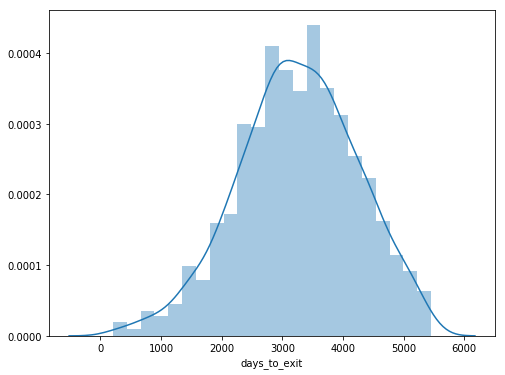

In [63]:
ax_dims = (8, 6)
f, ax = plt.subplots(figsize=ax_dims)
sns.distplot(exitdata.days_to_exit[(exitdata.year_founded >= 1999) & (exitdata.year_founded <= 2003)])

### Funding total (Exited companies)

C:\Users\Jeff Glupker\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


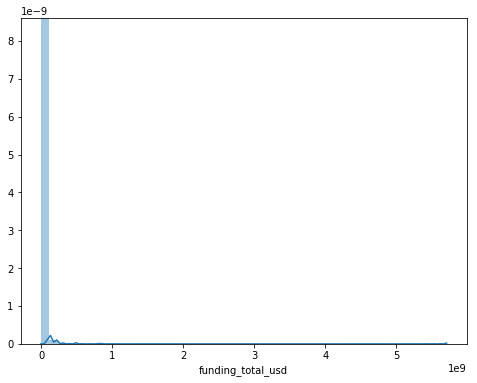

In [98]:
ax_dims = (8, 6)
f, ax = plt.subplots(figsize=ax_dims)
sns.distplot(exitdata.funding_total_usd[(exitdata.year_founded >= 1999) & (exitdata.year_founded <= 2003)])

### Days to Close

C:\Users\Jeff Glupker\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


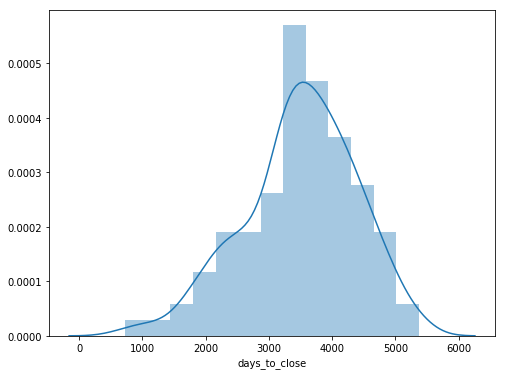

In [64]:
ax_dims = (8, 6)
f, ax = plt.subplots(figsize=ax_dims)
sns.distplot(closed.days_to_close[(closed.founded_year >= 1999) & (closed.founded_year <= 2003)])

### Funding Total (Closed Companies)

C:\Users\Jeff Glupker\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


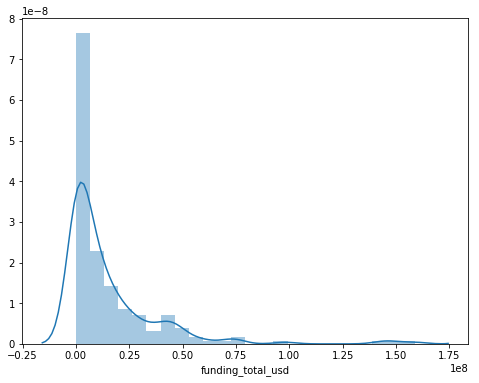

In [71]:
ax_dims = (8, 6)
f, ax = plt.subplots(figsize=ax_dims)
sns.distplot(closed.funding_total_usd[(closed.founded_year >= 1999) & (closed.founded_year <= 2003)])

## 2004-2008

### Days to Exit

C:\Users\Jeff Glupker\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


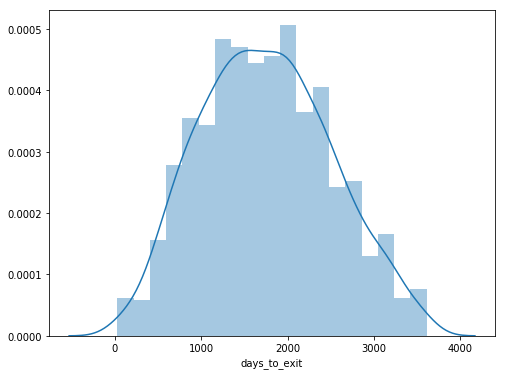

In [96]:
ax_dims = (8, 6)
f, ax = plt.subplots(figsize=ax_dims)
sns.distplot(exitdata.days_to_exit[(exitdata.year_founded >= 2004) & (exitdata.year_founded <= 2008)])

### Funding total (Exited companies)

C:\Users\Jeff Glupker\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


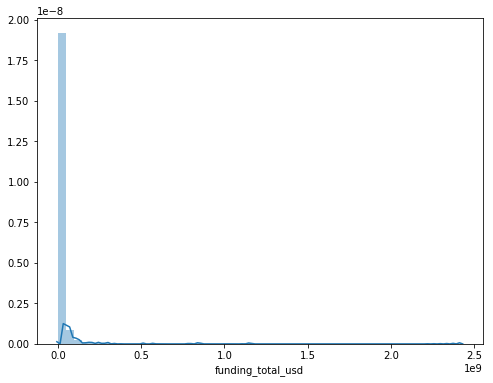

In [99]:
ax_dims = (8, 6)
f, ax = plt.subplots(figsize=ax_dims)
sns.distplot(exitdata.funding_total_usd[(exitdata.year_founded >= 2004) & (exitdata.year_founded <= 2008)])

### Days to Close

C:\Users\Jeff Glupker\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


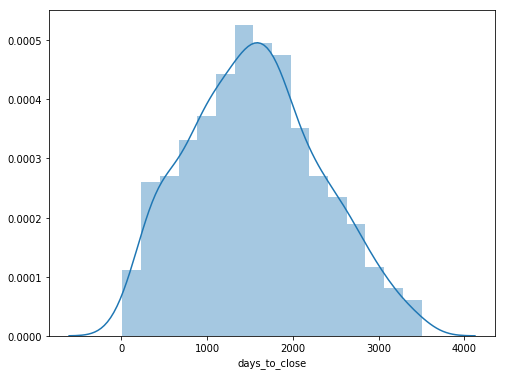

In [101]:
ax_dims = (8, 6)
f, ax = plt.subplots(figsize=ax_dims)
sns.distplot(closed.days_to_close[(closed.founded_year >= 2004) & (closed.founded_year <= 2008)])

### Funding Total (Closed Companies)

C:\Users\Jeff Glupker\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


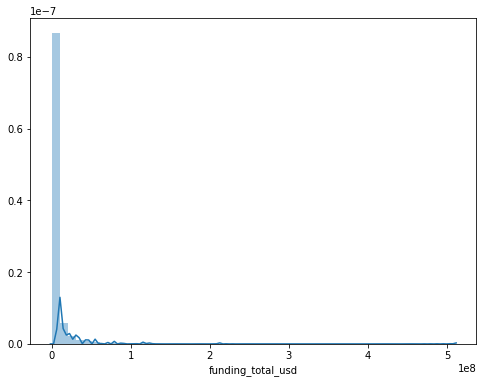

In [102]:
ax_dims = (8, 6)
f, ax = plt.subplots(figsize=ax_dims)
sns.distplot(closed.funding_total_usd[(closed.founded_year >= 2004) & (closed.founded_year <= 2008)])

## 2009-2013

### Days to Exit

C:\Users\Jeff Glupker\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


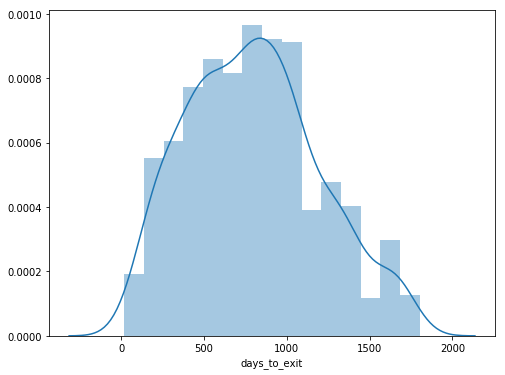

In [97]:
ax_dims = (8, 6)
f, ax = plt.subplots(figsize=ax_dims)
sns.distplot(exitdata.days_to_exit[(exitdata.year_founded >= 2009) & (exitdata.year_founded <= 2013)])

### Funding total (Exited companies)

C:\Users\Jeff Glupker\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


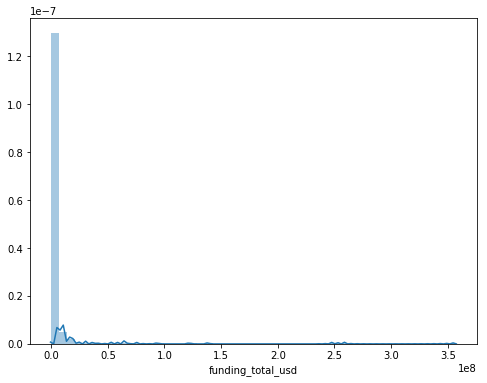

In [100]:
ax_dims = (8, 6)
f, ax = plt.subplots(figsize=ax_dims)
sns.distplot(exitdata.funding_total_usd[(exitdata.year_founded >= 2009) & (exitdata.year_founded <= 2013)])

### Days to Close

C:\Users\Jeff Glupker\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


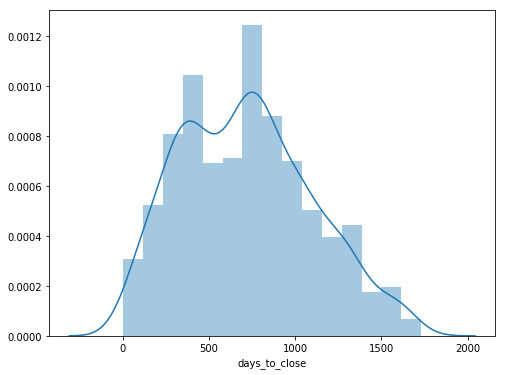

In [103]:
ax_dims = (8, 6)
f, ax = plt.subplots(figsize=ax_dims)
sns.distplot(closed.days_to_close[(closed.founded_year >= 2009) & (closed.founded_year <= 2013)])

### Funding Total (Closed Companies)

C:\Users\Jeff Glupker\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


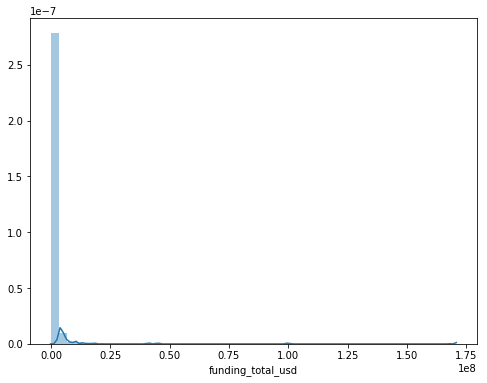

In [104]:
ax_dims = (8, 6)
f, ax = plt.subplots(figsize=ax_dims)
sns.distplot(closed.funding_total_usd[(closed.founded_year >= 2009) & (closed.founded_year <= 2013)])